In [1]:
import pandas as pd
from code.utilities import nlp_pipe, ml
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

plt.style.use('fivethirtyeight')
from collections import Counter
import spacy
nlp = spacy.load('en_core_web_sm')

In [2]:
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

## Read the data using pandas

In [3]:
# n_samples = 100
n_samples = 10_000
# read data
data = pd.read_csv('data/imdb_master.csv')
# remove unsupervised data
data=data[data.label != 'unsup']
# take a sample from the data as df
df= data.sample(n_samples, random_state=0)

## Keep text and sentiment and drop the other columns

In [4]:
df = df.drop(['Unnamed: 0', 'file', 'type'], axis=1)
df.columns = ['review', 'sentiment']
df=df[df.sentiment != 'unsup']
df.sentiment  = df.sentiment.map({'neg' : 0, 'pos' : 1})


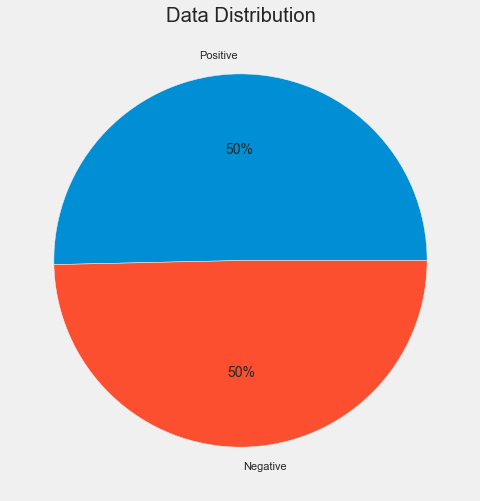

In [5]:
plt.figure(figsize=(8, 8))
plt.pie(df.sentiment.value_counts(), labels=['Positive', 'Negative'], autopct='%.0f%%')
plt.title('Data Distribution')
plt.show()

In [6]:
df['review_doc'] = list(nlp.pipe(df.review))

In [7]:
cv = nlp_pipe()
rs = cv.fit_transform(df.review)
new_df = pd.DataFrame(rs.toarray(), columns=cv.vectorizer.get_feature_names()) # TERM DOCUEMNT MATRIX

In [8]:
tv = nlp_pipe(TfidfVectorizer(stop_words='english', max_df=0.75, min_df=.40, max_features=10000, use_idf=False, norm=None))
rs2 = tv.fit_transform(df.review)
new_df2 = pd.DataFrame(rs2.toarray(), columns=tv.vectorizer.get_feature_names()) # TERM DOCUEMNT MATRIX

In [9]:
positive_reviews = df[df.sentiment==1]
negative_reviews = df[df.sentiment==0]

In [10]:
pos_adj = [token.text.lower() for doc in positive_reviews.review_doc for token in doc if token.pos_=='ADJ']
neg_adj = [token.text.lower() for doc in negative_reviews.review_doc for token in doc if token.pos_=='ADJ']

pos_noun = [token.text.lower() for doc in positive_reviews.review_doc for token in doc if token.pos_=='NOUN']
neg_noun = [token.text.lower() for doc in negative_reviews.review_doc for token in doc if token.pos_=='NOUN']

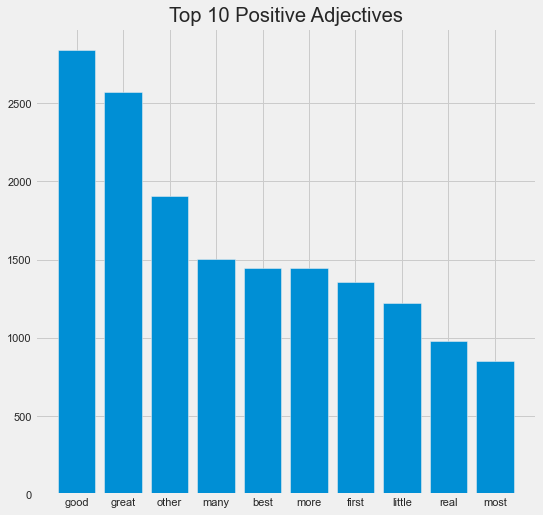

In [12]:
plt.figure(figsize=(8, 8))

Counter(pos_adj).most_common(10)
label = [x[0] for x in Counter(pos_adj).most_common(10) ]
freq = [x[1] for x in Counter(pos_adj).most_common(10) ]
plt.bar(label, freq)
plt.title('Top 10 Positive Adjectives')
plt.show()

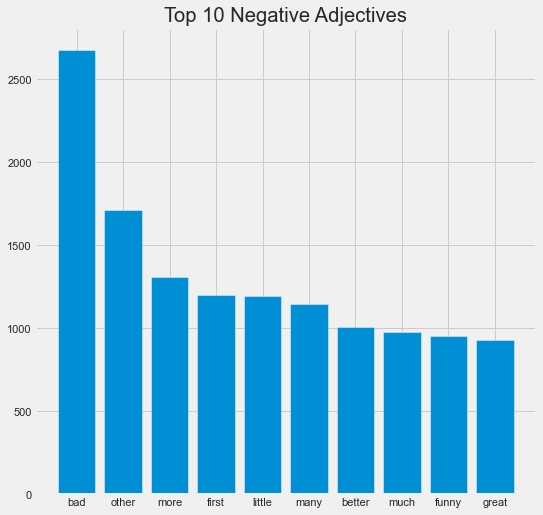

In [13]:
plt.figure(figsize=(8, 8))

Counter(neg_adj).most_common(10)
label = [x[0] for x in Counter(neg_adj).most_common(11) ]
freq = [x[1] for x in Counter(neg_adj).most_common(11) ]
plt.bar(label[1:], freq[1:])
plt.title('Top 10 Negative Adjectives')
plt.show()

In [14]:
num_words=15

vocab = np.array(tv.vectorizer.get_feature_names())

top_words = lambda t: [vocab[i] for i in np.argsort(t)[:-num_words-1:-1]]
topic_words = ([top_words(t) for t in new_df2.to_numpy()])
topics = [' '.join(t) for t in topic_words]

In [16]:
pca_6 = PCA(n_components=900)
# pca_6 = PCA(n_components=2000)
pca_6.fit_transform(new_df.T)
np.cumsum(pca_6.explained_variance_ratio_*100)

array([15.14736493, 18.59556717, 20.01483771, 20.76170276, 21.42409142,
       22.0396661 , 22.62446118, 23.18589661, 23.71913435, 24.21784621,
       24.69774535, 25.13308682, 25.55298198, 25.97088791, 26.35283344,
       26.71536058, 27.06389315, 27.4021553 , 27.73077082, 28.05518413,
       28.3618056 , 28.66745507, 28.96606081, 29.25499466, 29.53856451,
       29.8153099 , 30.08690632, 30.35019293, 30.61078882, 30.8658013 ,
       31.11203507, 31.35642647, 31.5944483 , 31.82590506, 32.05470553,
       32.28144323, 32.50721965, 32.72897544, 32.95005362, 33.1670534 ,
       33.3788618 , 33.58808117, 33.79460889, 34.00008379, 34.20200648,
       34.4035407 , 34.60248596, 34.80103211, 34.99498757, 35.18660581,
       35.37430102, 35.55990439, 35.74384253, 35.92443973, 36.10154582,
       36.27630885, 36.44759424, 36.61801035, 36.78475275, 36.94943437,
       37.1119878 , 37.27102793, 37.42887687, 37.58556397, 37.741539  ,
       37.89461055, 38.04619828, 38.19550182, 38.34335671, 38.48

In [17]:
# import seaborn as sns
# sns.set()


Text(0, 0.5, 'Explained Variance')

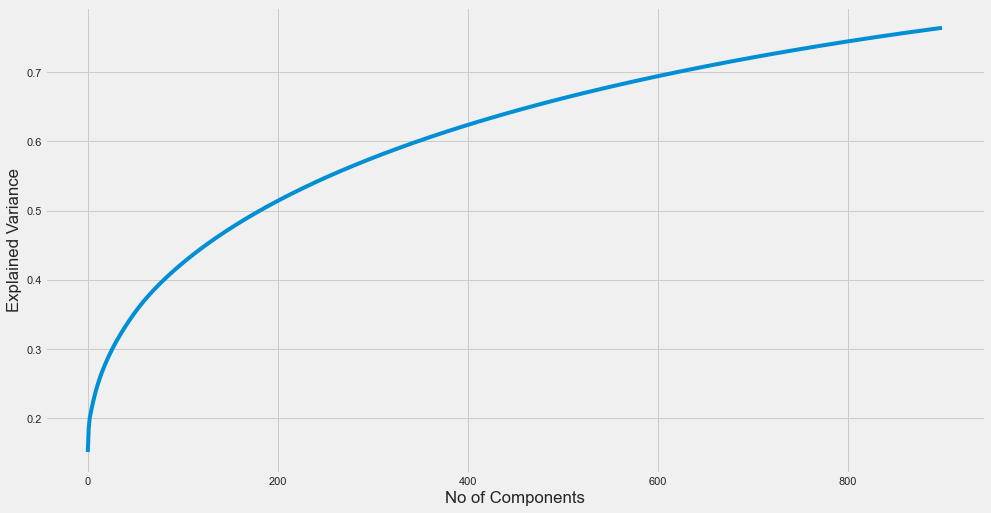

In [18]:
plt.figure(figsize=(15,8))
plt.plot(np.cumsum(pca_6.explained_variance_ratio_))
plt.xlabel('No of Components')
plt.ylabel('Explained Variance')

In [19]:
pca_df = pd.DataFrame(pca_6.components_.T)

In [20]:
pca_df['sentiment'] =df.sentiment.reset_index().sentiment

In [21]:
y = df.sentiment.reset_index().sentiment
x = pd.DataFrame(pca_6.components_.T)
x_train, x_test, y_train, y_test = train_test_split( x, y, test_size=0.3, random_state=123) 

In [22]:
knn = KNeighborsClassifier(n_neighbors = 5)
Log_Reg = LogisticRegression()
dtree = DecisionTreeClassifier()
rf = RandomForestClassifier()

KNN_3 = KNeighborsClassifier(n_neighbors = 40)

KNN_2 = KNeighborsClassifier()
param_grid = {'n_neighbors': np.arange(1, 100)}
KNN_gscv = GridSearchCV(KNN_2, param_grid, cv=5)



In [23]:
dic = {'KNN_5': knn,'KNN_gscv': KNN_gscv,
       'Logistic Regression': Log_Reg, 'DTree': dtree, 'RForest':rf}

machines = ml(dic)
machines.fit(x_train, y_train)
y_predict = machines.predict(x_test)

In [24]:
machines.machines['KNN_gscv'].best_params_


{'n_neighbors': 14}

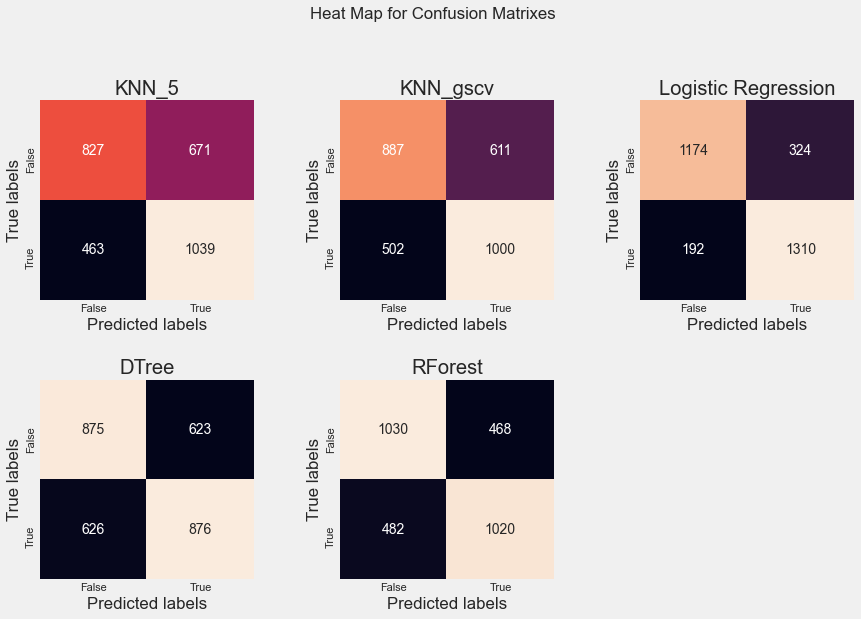

In [25]:
machines.plot_heatmap(y_test, rows=3, columns=3)

In [26]:
machines.get_info()

                         Models Results                         
┏━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃ Model                ┃ Accuracy ┃ Precision ┃ Recall ┃  F1   ┃
┡━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ KNN_5                │   62.2   │   60.76   │ 69.17  │ 64.69 │
│ KNN_gscv             │   62.9   │   62.07   │ 66.58  │ 64.25 │
│ Logistic Regression  │   82.8   │   80.17   │ 87.22  │ 83.55 │
│ DTree                │  58.37   │   58.44   │ 58.32  │ 58.38 │
│ RForest              │  68.33   │   68.55   │ 67.91  │ 68.23 │
└──────────────────────┴──────────┴───────────┴────────┴───────┘

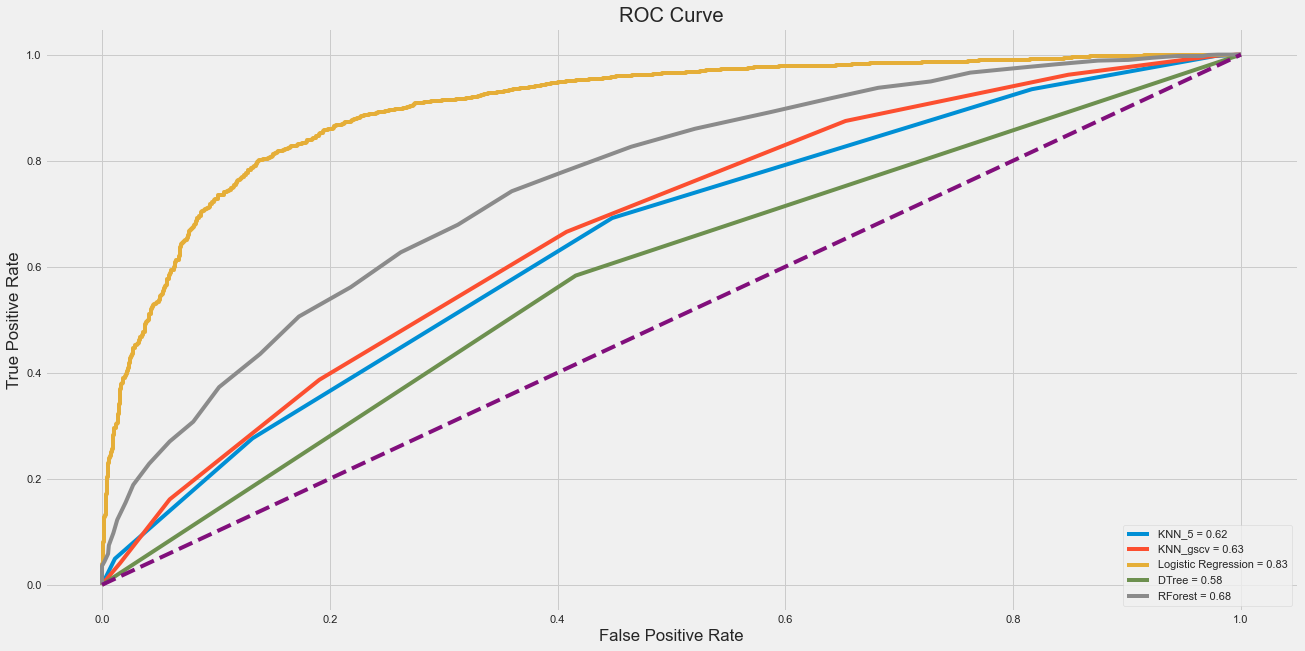

In [27]:
machines.plot_roc()